# AttriPredict - Brute-Force LR Playbook

Hyper-focused LR lab that brute-forces feature stacks, resampling recipes, and regularisation styles to ship both a production-stable bundle and a leaderboard-slayer.

## Notebook Roadmap
- Aggressive preprocessing utilities (quantile warping, bin stacking, interaction factories)
- Auto-generated LR scenario grid (60 plug-and-play variants across pipelines, samplers, CV + voting)
- Expanded evaluation: CV ensembles, metric dashboards, leaderboard vs production scoring
- Final export: dual bundles, diagnostics, and comparison-ready artifacts

In [1]:
import warnings
warnings.filterwarnings("ignore")

import json
import copy
import time
from datetime import datetime
from itertools import product
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.calibration import calibration_curve
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import (
    KBinsDiscretizer,
    OneHotEncoder,
    PolynomialFeatures,
    QuantileTransformer,
    StandardScaler,
)
from sklearn.feature_selection import SelectKBest, f_classif

try:
    from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
    from imblearn.combine import SMOTETomek, SMOTEENN
    HAS_IMB = True
except Exception:
    HAS_IMB = False
    SMOTE = ADASYN = BorderlineSMOTE = SMOTETomek = SMOTEENN = None
    print("[WARN] imblearn not available; SMOTE-based recipes will be degraded.")


In [2]:

# Paths and configuration
DATA_DIR = Path("../../data")
OUTPUT_DIR = Path("artifacts")
SUMMARY_DIR = OUTPUT_DIR / "summaries"

for path in [OUTPUT_DIR, SUMMARY_DIR]:
    path.mkdir(parents=True, exist_ok=True)

SCENARIO_DIR_CACHE: Dict[str, Dict[str, Path]] = {}

def get_scenario_dirs(name: str) -> Dict[str, Path]:
    if name not in SCENARIO_DIR_CACHE:
        base = OUTPUT_DIR / name
        layout = {
            "base": base,
            "models": base / "models",
            "figures": base / "figures",
            "data": base / "data",
        }
        for path in layout.values():
            path.mkdir(parents=True, exist_ok=True)
        SCENARIO_DIR_CACHE[name] = layout
    return SCENARIO_DIR_CACHE[name]

TARGET_COL = "Attrition"
NOMINAL_FEATURES = [
    "BusinessTravel",
    "Department",
    "EducationField",
    "Gender",
    "JobRole",
    "MaritalStatus",
    "OverTime",
]
RANDOM_SEEDS = [42, 1337, 2024]
BASELINE_AUC = 0.8797

print(f"Artifacts root: {OUTPUT_DIR.resolve()}")

Artifacts root: D:\Files\Develop Projects\ITHM\Projects\AttriPredict\src\02_brute-force_lr_playbook\artifacts


In [3]:
# Load data
train_df = pd.read_csv(DATA_DIR / "train.csv")
test_df = pd.read_csv(DATA_DIR / "test.csv")

drop_cols = ["Over18", "StandardHours", "EmployeeNumber"]
train_df = train_df.drop(columns=drop_cols)
test_df = test_df.drop(columns=drop_cols)

X_train_full = train_df.drop(columns=[TARGET_COL])
y_train_full = train_df[TARGET_COL].astype(int)
X_test_full = test_df.drop(columns=[TARGET_COL])
y_test_full = test_df[TARGET_COL].astype(int)

print(f"Train shape: {X_train_full.shape}, attrition rate: {y_train_full.mean():.3f}")
print(f"Test  shape: {X_test_full.shape}, attrition rate: {y_test_full.mean():.3f}")

Train shape: (1100, 27), attrition rate: 0.162
Test  shape: (350, 27), attrition rate: 0.151


In [4]:
def build_sampler(config: Optional[Dict[str, Any]]):
    if not config or not HAS_IMB:
        return None
    name = config.get("name", "smote").lower()
    params = dict(config.get("params", {}))
    params.setdefault("random_state", config.get("random_state", 42))
    if name == "smote" and SMOTE is not None:
        return SMOTE(**params)
    if name == "adasyn" and ADASYN is not None:
        return ADASYN(**params)
    if name == "borderlinesmote" and BorderlineSMOTE is not None:
        return BorderlineSMOTE(**params)
    if name == "smoteenn" and SMOTEENN is not None:
        return SMOTEENN(**params)
    if name == "smotetomek" and SMOTETomek is not None:
        return SMOTETomek(**params)
    raise ValueError(f"Sampler '{name}' unavailable in current environment.")


def apply_sampler(df: pd.DataFrame, y: np.ndarray, config: Optional[Dict[str, Any]]):
    if not config:
        return df, y
    sampler = build_sampler(config)
    X_res, y_res = sampler.fit_resample(df.values, y) # type: ignore
    df_res = pd.DataFrame(X_res, columns=df.columns)
    return df_res, y_res

def log_progress(message: str, scenario: Optional[str] = None) -> None:
    timestamp = datetime.now().strftime("%H:%M:%S")
    prefix = f"[{timestamp}]"
    if scenario:
        prefix += f"[{scenario}]"
    print(f"{prefix} {message}")


In [5]:
class FeaturePipeline:
    def __init__(self, config: Optional[Dict[str, Any]] = None, nominal_features: Optional[List[str]] = None):
        self.config = config or {}
        self.nominal_features = nominal_features or NOMINAL_FEATURES
        self.skew_threshold = self.config.get("skew_threshold", 0.5)

        self.encoder: Optional[OneHotEncoder] = None
        self.numeric_columns: List[str] = []
        self.basic_columns: List[str] = []
        self.scaled_columns: List[str] = []
        self.skewed_features: List[str] = []
        self.log_shifts: Dict[str, float] = {}
        self.scaler: Optional[StandardScaler] = None

        self.quantile_transformer: Optional[QuantileTransformer] = None
        self.quantile_columns: List[str] = []

        self.binner: Optional[KBinsDiscretizer] = None
        self.bin_columns: List[str] = []
        self.bin_feature_names: List[str] = []
        self.bin_drop_original: bool = False

        self.pre_advanced_columns: List[str] = []
        self.advanced_added: List[str] = []

        self.poly: Optional[PolynomialFeatures] = None
        self.poly_base_cols: List[str] = []
        self.poly_new_cols: List[str] = []

        self.selector = None
        self.selected_columns: Optional[List[str]] = None


        self.feature_columns: Optional[List[str]] = None

    def _ensure_unique_columns(self, df: pd.DataFrame, stage: str) -> pd.DataFrame:
        duplicated = df.columns[df.columns.duplicated()].tolist()
        if not duplicated:
            return df
        labels = sorted(set(duplicated))
        preview = ", ".join(labels[:5])
        suffix = ", ..." if len(labels) > 5 else ""
        print(f"[FeaturePipeline] Stage '{stage}' dropped duplicate columns: {preview}{suffix}")
        return df.loc[:, ~df.columns.duplicated()].copy()

    def _build_encoder(self) -> OneHotEncoder:
        try:
            encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
        except TypeError:
            encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
        return encoder

    def _encoder_feature_names(self) -> List[str]:
        if hasattr(self.encoder, "get_feature_names_out"):
            return list(self.encoder.get_feature_names_out(self.nominal_features)) # type: ignore
        return list(self.encoder.get_feature_names(self.nominal_features)) # type: ignore

    def _fit_basic(self, X: pd.DataFrame) -> pd.DataFrame:
        X_num = X.drop(columns=self.nominal_features)
        self.numeric_columns = X_num.columns.tolist()

        self.encoder = self._build_encoder()
        encoded = self.encoder.fit_transform(X[self.nominal_features])
        encoded_df = pd.DataFrame(encoded, columns=self._encoder_feature_names(), index=X.index)

        X_proc = pd.concat([X_num, encoded_df], axis=1)
        self.basic_columns = X_proc.columns.tolist()
        self.skewed_features = []
        self.log_shifts = {}
        for col in self.basic_columns:
            series = X_proc[col].astype(float)
            skew_value = float(series.skew()) # type: ignore
            if np.isnan(skew_value):
                continue
            if abs(skew_value) > self.skew_threshold:
                shift = 0.0
                min_val = series.min()
                if min_val <= -1.0:
                    shift = abs(min_val) + 1.0
                self.log_shifts[col] = shift
                X_proc[col] = np.log1p(series + shift)
                self.skewed_features.append(col)

        if self.config.get("quantile_transform"):
            X_proc = self._fit_quantile_transform(X_proc)
        else:
            self.quantile_transformer = None
            self.quantile_columns = []

        if self.config.get("numeric_binning"):
            X_proc = self._fit_numeric_binning(X_proc)
        else:
            self.binner = None
            self.bin_columns = []
            self.bin_feature_names = []
            self.bin_drop_original = False

        X_proc = self._ensure_unique_columns(X_proc, "basic_fit")
        self.basic_columns = X_proc.columns.tolist()

        self.scaler = StandardScaler()
        scaled = self.scaler.fit_transform(X_proc)
        X_scaled = pd.DataFrame(scaled, columns=X_proc.columns, index=X_proc.index)
        self.scaled_columns = X_scaled.columns.tolist()
        return X_scaled

    def _transform_basic(self, X: pd.DataFrame) -> pd.DataFrame:
        X_num = X[self.numeric_columns].copy()
        encoded = self.encoder.transform(X[self.nominal_features]) # type: ignore
        encoded_df = pd.DataFrame(encoded, columns=self._encoder_feature_names(), index=X.index) # type: ignore

        X_proc = pd.concat([X_num, encoded_df], axis=1)
        for col in self.skewed_features:
            shift = self.log_shifts.get(col, 0.0)
            X_proc[col] = np.log1p(X_proc[col].astype(float) + shift)

        if self.quantile_transformer is not None:
            X_proc = self._transform_quantile_transform(X_proc)

        if self.binner is not None:
            X_proc = self._transform_numeric_binning(X_proc)

        X_proc = self._ensure_unique_columns(X_proc, "basic_transform")
        X_proc = X_proc.reindex(columns=self.basic_columns, fill_value=0.0)

        scaled = self.scaler.transform(X_proc) # type: ignore
        X_scaled = pd.DataFrame(scaled, columns=X_proc.columns, index=X_proc.index)
        return X_scaled

    def _fit_quantile_transform(self, df: pd.DataFrame) -> pd.DataFrame:
        cfg = self.config.get("quantile_transform") or {}
        n_samples = len(df)
        columns = cfg.get("columns")
        if columns is None:
            columns = [col for col in self.numeric_columns if col in df.columns]
        else:
            columns = [col for col in columns if col in df.columns]
        if not columns:
            self.quantile_transformer = None
            self.quantile_columns = []
            return df

        params = {
            "n_quantiles": min(cfg.get("n_quantiles", 200), n_samples),
            "output_distribution": cfg.get("output_distribution", "normal"),
            "subsample": cfg.get("subsample", 1_000_000),
            "random_state": cfg.get("random_state", 42),
        }
        transformer = QuantileTransformer(**params)
        df.loc[:, columns] = transformer.fit_transform(df[columns])
        self.quantile_transformer = transformer
        self.quantile_columns = columns
        return df

    def _transform_quantile_transform(self, df: pd.DataFrame) -> pd.DataFrame:
        if self.quantile_transformer is None or not self.quantile_columns:
            return df
        cols = [col for col in self.quantile_columns if col in df.columns]
        if not cols:
            return df
        df.loc[:, cols] = self.quantile_transformer.transform(df[cols])
        return df

    def _fit_numeric_binning(self, df: pd.DataFrame) -> pd.DataFrame:
        cfg = self.config.get("numeric_binning") or {}
        columns = cfg.get("columns")
        if columns is None:
            columns = [col for col in self.numeric_columns if col in df.columns]
        else:
            columns = [col for col in columns if col in df.columns]

        min_unique = cfg.get("min_unique", 8)
        columns = [col for col in columns if df[col].nunique() >= min_unique]
        if not columns:
            self.binner = None
            self.bin_columns = []
            self.bin_feature_names = []
            self.bin_drop_original = False
            return df

        self.bin_drop_original = bool(cfg.get("drop_original", False))
        n_bins = cfg.get("n_bins", 5)
        encode = cfg.get("encode", "onehot-dense")
        strategy = cfg.get("strategy", "quantile")

        binner = KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy)
        binner.fit(df[columns])
        arr = binner.transform(df[columns])
        if hasattr(arr, "toarray"):
            arr = arr.toarray() # type: ignore

        bin_names: List[str] = []
        for col, bins in zip(columns, binner.n_bins_):
            for idx in range(int(bins)):
                bin_names.append(f"{col}_bin_{idx}")

        base_df = df.drop(columns=columns) if self.bin_drop_original else df
        bin_df = pd.DataFrame(arr, columns=bin_names, index=df.index) # type: ignore
        df_aug = pd.concat([base_df, bin_df], axis=1)

        self.binner = binner
        self.bin_columns = columns
        self.bin_feature_names = bin_names
        return df_aug

    def _transform_numeric_binning(self, df: pd.DataFrame) -> pd.DataFrame:
        if self.binner is None or not self.bin_columns:
            return df
        missing = [col for col in self.bin_columns if col not in df.columns]
        if missing:
            return df
        arr = self.binner.transform(df[self.bin_columns])
        if hasattr(arr, "toarray"):
            arr = arr.toarray() # type: ignore
        bin_df = pd.DataFrame(arr, columns=self.bin_feature_names, index=df.index) # type: ignore
        base_df = df.drop(columns=self.bin_columns) if self.bin_drop_original else df
        df_aug = pd.concat([base_df, bin_df], axis=1)
        return df_aug

    def _generate_advanced(self, df: pd.DataFrame) -> Tuple[pd.DataFrame, List[str]]:
        cfg = self.config.get("advanced_config", {})
        df_aug = df.copy()
        added: List[str] = []

        interactions = cfg.get(
            "interaction_pairs",
            [
                ("Age", "MonthlyIncome"),
                ("DistanceFromHome", "OverTime_Yes"),
                ("YearsAtCompany", "JobLevel"),
                ("TotalWorkingYears", "Age"),
                ("WorkLifeBalance", "OverTime_Yes"),
                ("JobSatisfaction", "EnvironmentSatisfaction"),
                ("MonthlyIncome", "JobLevel"),
                ("TotalWorkingYears", "NumCompaniesWorked"),
            ],
        )
        for col1, col2 in interactions:
            if col1 in df_aug.columns and col2 in df_aug.columns:
                name = f"{col1}_x_{col2}"
                df_aug[name] = df_aug[col1] * df_aug[col2]
                added.append(name)

        ratio_specs = cfg.get(
            "ratio_features",
            [
                ("MonthlyIncome", "Age", "Income_per_Age"),
                ("YearsAtCompany", "TotalWorkingYears", "Company_vs_Total_Years"),
                ("YearsSinceLastPromotion", "YearsAtCompany", "Promotion_Frequency"),
                ("YearsWithCurrManager", "YearsInCurrentRole", "Manager_Stability"),
                ("TotalWorkingYears", "NumCompaniesWorked", "Years_per_Company"),
            ],
        )
        for num_col, denom_col, name in ratio_specs:
            if num_col in df_aug.columns and denom_col in df_aug.columns:
                df_aug[name] = df_aug[num_col] / (df_aug[denom_col] + 1e-5)
                added.append(name)

        delta_specs = cfg.get(
            "delta_features",
            [
                ("YearsAtCompany", "YearsInCurrentRole", "Tenure_vs_Role"),
                ("YearsAtCompany", "YearsWithCurrManager", "Tenure_vs_Manager"),
                ("PerformanceRating", "EnvironmentSatisfaction", "Performance_minus_Environment"),
            ],
        )
        for top_col, bottom_col, name in delta_specs:
            if top_col in df_aug.columns and bottom_col in df_aug.columns:
                df_aug[name] = df_aug[top_col] - df_aug[bottom_col]
                added.append(name)

        satisfaction_cols = cfg.get(
            "satisfaction_cols",
            ["JobSatisfaction", "EnvironmentSatisfaction", "RelationshipSatisfaction", "WorkLifeBalance"],
        )
        if all(col in df_aug.columns for col in satisfaction_cols):
            df_aug["Satisfaction_Mean"] = df_aug[satisfaction_cols].mean(axis=1)
            df_aug["Satisfaction_Std"] = df_aug[satisfaction_cols].std(axis=1)
            df_aug["Satisfaction_Max"] = df_aug[satisfaction_cols].max(axis=1)
            added.extend(["Satisfaction_Mean", "Satisfaction_Std", "Satisfaction_Max"])

        return df_aug, added

    def _fit_advanced(self, df: pd.DataFrame) -> pd.DataFrame:
        self.pre_advanced_columns = df.columns.tolist()

        df_aug, added = self._generate_advanced(df)
        df_aug = self._ensure_unique_columns(df_aug, "advanced_fit")
        unique_added: List[str] = []
        seen = set()
        for name in added:
            if name in df_aug.columns and name not in seen:
                unique_added.append(name)
                seen.add(name)
        self.advanced_added = unique_added
        return df_aug


    def _transform_advanced(self, df: pd.DataFrame) -> pd.DataFrame:

        df_aug, _ = self._generate_advanced(df)
        df_aug = self._ensure_unique_columns(df_aug, "advanced_transform")
        for col in self.advanced_added:
            if col not in df_aug.columns:
                df_aug[col] = 0.0
        ordered = list(dict.fromkeys(self.pre_advanced_columns + self.advanced_added))
        df_aug = df_aug.reindex(columns=ordered, fill_value=0.0)
        return df_aug


    def _fit_poly(self, df: pd.DataFrame) -> pd.DataFrame:
        cfg = self.config.get("poly") or {}
        degree = cfg.get("degree", 2)
        interaction_only = cfg.get("interaction_only", False)
        include_bias = cfg.get("include_bias", False)
        max_base = cfg.get("max_base_features", 12)
        base_cols = cfg.get("columns")

        if base_cols is None:
            variances = df.var().sort_values(ascending=False)
            top_n = min(max_base, len(variances))
            base_cols = list(variances.head(top_n).index)
        base_cols = [col for col in base_cols if col in df.columns]
        if not base_cols:
            self.poly = None
            self.poly_base_cols = []
            self.poly_new_cols = []
            return df

        poly = PolynomialFeatures(
            degree=degree,
            interaction_only=interaction_only,
            include_bias=include_bias,
        )
        arr = poly.fit_transform(df[base_cols])
        names = poly.get_feature_names_out(base_cols)
        poly_df = pd.DataFrame(arr, columns=names, index=df.index)

        new_cols = [col for col in names if col not in df.columns]
        df_aug = pd.concat([df, poly_df[new_cols]], axis=1)

        self.poly = poly
        self.poly_base_cols = base_cols
        self.poly_new_cols = new_cols
        return df_aug

    def _transform_poly(self, df: pd.DataFrame) -> pd.DataFrame:
        if self.poly is None or not self.poly_base_cols:
            return df
        poly_arr = self.poly.transform(df[self.poly_base_cols])
        names = self.poly.get_feature_names_out(self.poly_base_cols)
        poly_df = pd.DataFrame(poly_arr, columns=names, index=df.index) # type: ignore
        if self.poly_new_cols:
            df_aug = pd.concat([df, poly_df[self.poly_new_cols]], axis=1)
        else:
            df_aug = df
        return df_aug

    def _fit_selector(self, df: pd.DataFrame, y: np.ndarray) -> pd.DataFrame:
        selector_cfg = self.config.get("feature_selector") or {}
        strategy = selector_cfg.get("strategy", "selectk").lower()
        if strategy == "selectk":
            k = selector_cfg.get("k", min(120, df.shape[1]))
            k = min(k, df.shape[1])
            selector = SelectKBest(score_func=f_classif, k=k)
        else:
            raise ValueError(f"Unsupported selector strategy '{strategy}' for FeaturePipeline.")
        arr = selector.fit_transform(df.values, y)
        selected_cols = df.columns[selector.get_support()]
        df_sel = pd.DataFrame(arr, columns=selected_cols, index=df.index)
        self.selector = selector
        self.selected_columns = selected_cols.tolist()
        return df_sel

    def _transform_selector(self, df: pd.DataFrame) -> pd.DataFrame:
        if self.selector is None:
            return df
        arr = self.selector.transform(df.values)
        df_sel = pd.DataFrame(arr, columns=self.selected_columns, index=df.index) # type: ignore
        return df_sel

    def fit_transform_train(self, X: pd.DataFrame, y: np.ndarray) -> Tuple[pd.DataFrame, np.ndarray]:
        samplers = self.config.get("samplers", {}) or {}
        y_array = np.asarray(y).ravel()

        X_basic = self._fit_basic(X)
        self.pre_advanced_columns = list(dict.fromkeys(X_basic.columns.tolist()))
        y_current = y_array

        if samplers.get("basic"):
            X_basic, y_current = apply_sampler(X_basic, y_current, samplers.get("basic"))

        X_proc = X_basic
        if self.config.get("use_advanced", False):
            X_proc = self._fit_advanced(X_proc)
        else:
            self.advanced_added = []
            self.pre_advanced_columns = X_proc.columns.tolist()

        if self.config.get("poly"):
            X_proc = self._fit_poly(X_proc)
        else:
            self.poly = None
            self.poly_base_cols = []
            self.poly_new_cols = []

        if self.config.get("feature_selector"):
            X_proc = self._fit_selector(X_proc, y_current) # type: ignore
        else:
            self.selector = None
            self.selected_columns = None

        if samplers.get("advanced"):
            X_proc, y_current = apply_sampler(X_proc, y_current, samplers.get("advanced")) # type: ignore

        X_proc = self._ensure_unique_columns(X_proc, "fit_finalize")
        self.feature_columns = X_proc.columns.tolist()
        return X_proc, y_current # type: ignore

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:

        X_basic = self._transform_basic(X)
        X_basic = self._ensure_unique_columns(X_basic, "transform_basic")
        if not self.pre_advanced_columns:
            self.pre_advanced_columns = list(dict.fromkeys(X_basic.columns.tolist()))

        X_proc = X_basic
        if self.config.get("use_advanced", False):
            X_proc = self._transform_advanced(X_basic)
            X_proc = self._ensure_unique_columns(X_proc, "transform_advanced")
        else:
            X_proc = X_basic.reindex(columns=self.pre_advanced_columns, fill_value=0.0)

        if self.config.get("poly"):
            X_proc = self._transform_poly(X_proc)
            X_proc = self._ensure_unique_columns(X_proc, "transform_poly")

        if self.selector is not None:
            X_proc = self._transform_selector(X_proc)

        X_proc = self._ensure_unique_columns(X_proc, "transform_finalize")
        if self.feature_columns is not None:
            X_proc = X_proc.reindex(columns=self.feature_columns, fill_value=0.0)

        return X_proc


    def get_feature_names(self) -> List[str]:
        return list(self.feature_columns or [])


In [6]:

def build_cv(strategy: Dict[str, Any], seed: int):
    mode = strategy.get("mode", "kfold")
    n_splits = strategy.get("n_splits", 5)
    if mode == "kfold":
        return StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    if mode == "repeated":
        n_repeats = strategy.get("n_repeats", 3)
        return RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=seed)
    raise ValueError(f"Unknown CV mode '{mode}'")


def find_threshold(y_true: np.ndarray, probs: np.ndarray, strategy: str, params: Optional[Dict[str, Any]] = None) -> float:
    params = params or {}
    if strategy == "default":
        return 0.5

    thresholds = np.linspace(0.05, 0.95, 181)
    best_threshold = 0.5
    best_score = -np.inf

    if strategy == "max_f1":
        for t in thresholds:
            preds = (probs >= t).astype(int)
            score = f1_score(y_true, preds, zero_division=0)
            if score > best_score:
                best_score = score
                best_threshold = float(t)
        return best_threshold

    if strategy == "balanced_precision_recall":
        weight = params.get("recall_weight", 0.5)
        for t in thresholds:
            preds = (probs >= t).astype(int)
            prec = precision_score(y_true, preds, zero_division=0)
            rec = recall_score(y_true, preds, zero_division=0)
            score = weight * rec + (1.0 - weight) * prec
            if score > best_score:
                best_score = score
                best_threshold = float(t)
        return best_threshold

    if strategy == "recall_floor":
        min_recall = params.get("min_recall", 0.75)
        best_precision = -np.inf
        for t in thresholds:
            preds = (probs >= t).astype(int)
            rec = recall_score(y_true, preds, zero_division=0)
            prec = precision_score(y_true, preds, zero_division=0)
            if rec >= min_recall and prec > best_precision:
                best_precision = prec
                best_threshold = float(t)
        return best_threshold

    return best_threshold


def compute_metrics(y_true: np.ndarray, probs: np.ndarray, threshold: float) -> Dict[str, float]:
    preds = (probs >= threshold).astype(int)
    return {
        "auc": float(roc_auc_score(y_true, probs)),
        "pr_auc": float(average_precision_score(y_true, probs)),
        "precision": float(precision_score(y_true, preds, zero_division=0)),
        "recall": float(recall_score(y_true, preds, zero_division=0)),
        "f1": float(f1_score(y_true, preds, zero_division=0)),
    }


def plot_roc_curve(ax, y_true: np.ndarray, probs: np.ndarray, label: str):
    fpr, tpr, _ = roc_curve(y_true, probs)
    auc_value = roc_auc_score(y_true, probs)
    ax.plot(fpr, tpr, label=f"{label} (AUC={auc_value:.3f})", linewidth=2)
    ax.plot([0, 1], [0, 1], linestyle="--", color="grey", alpha=0.6)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve")
    ax.legend(loc="lower right")
    ax.grid(alpha=0.2)


def plot_pr_curve(ax, y_true: np.ndarray, probs: np.ndarray, label: str):
    precision, recall, _ = precision_recall_curve(y_true, probs)
    ap = average_precision_score(y_true, probs)
    ax.plot(recall, precision, label=f"{label} (AP={ap:.3f})", linewidth=2)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Precision-Recall Curve")
    ax.legend(loc="lower left")
    ax.grid(alpha=0.2)


def plot_confusion(ax, cm: np.ndarray, labels: List[str], title: str):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_title(title)


def plot_cv_distribution(ax, seed_summaries: List[Dict[str, Any]], title: str):
    rows = []
    for seed_info in seed_summaries:
        for fold_idx, score in enumerate(seed_info["cv_scores"]):
            rows.append({"seed": seed_info["seed"], "fold": fold_idx, "auc": score})
    cv_df = pd.DataFrame(rows)
    sns.boxplot(data=cv_df, x="seed", y="auc", ax=ax, palette="Set2")
    ax.axhline(BASELINE_AUC, linestyle="--", color="grey", alpha=0.6, label="Baseline")
    ax.set_title(title)
    ax.set_xlabel("Seed")
    ax.set_ylabel("Fold AUC")
    ax.legend()
    ax.grid(alpha=0.2)


def plot_calibration(ax, y_true: np.ndarray, probs: np.ndarray, label: str, n_bins: int = 10):
    prob_true, prob_pred = calibration_curve(y_true, probs, n_bins=n_bins, strategy="quantile")
    ax.plot(prob_pred, prob_true, marker="o", linewidth=2, label=label)
    ax.plot([0, 1], [0, 1], linestyle="--", color="grey", alpha=0.7, label="Perfect calibration")
    ax.set_title("Calibration Curve")
    ax.set_xlabel("Predicted probability")
    ax.set_ylabel("Observed probability")
    ax.legend(loc="upper left")
    ax.grid(alpha=0.2)


def plot_probability_hist(ax, y_true: np.ndarray, probs: np.ndarray):
    df = pd.DataFrame({"prob": probs, "actual": y_true}).copy()
    df["actual_label"] = df["actual"].map({0: "Stay", 1: "Leave"})
    sns.histplot(data=df, x="prob", hue="actual_label", bins=20, stat="density", common_norm=False, alpha=0.6, ax=ax)
    ax.set_title("Prediction Distribution by Class")
    ax.set_xlabel("Predicted probability")
    ax.set_ylabel("Density")
    ax.legend(title="Actual")
    ax.grid(alpha=0.2)


def prepare_cumulative_gain(y_true: np.ndarray, probs: np.ndarray) -> Tuple[pd.DataFrame, float]:
    df = pd.DataFrame({"actual": y_true, "prob": probs}).sort_values("prob", ascending=False).reset_index(drop=True)
    df["cum_pos"] = df["actual"].cumsum()
    total_pos = df["actual"].sum()
    total = len(df)
    if total == 0 or total_pos == 0:
        frac = np.linspace(0, 1, 11)
        res = pd.DataFrame({"fraction": frac, "gain": frac, "lift": np.ones_like(frac)})
        return res, 0.0
    df["fraction"] = (df.index + 1) / total
    df["gain"] = df["cum_pos"] / total_pos
    df["lift"] = df["gain"] / np.where(df["fraction"] == 0, np.nan, df["fraction"])
    df = df.fillna(1.0)
    base_rate = total_pos / total
    return df, base_rate


def plot_gain_curve(ax, gain_df: pd.DataFrame):
    ax.plot(gain_df["fraction"], gain_df["gain"], linewidth=2)
    ax.plot([0, 1], [0, 1], linestyle="--", color="grey", alpha=0.6)
    ax.set_title("Cumulative Gain")
    ax.set_xlabel("Fraction of samples")
    ax.set_ylabel("Fraction of positives captured")
    ax.grid(alpha=0.2)


def plot_lift_curve(ax, gain_df: pd.DataFrame, base_rate: float):
    ax.plot(gain_df["fraction"], gain_df["lift"], linewidth=2)
    ax.axhline(1.0, linestyle="--", color="grey", alpha=0.6)
    if base_rate:
        ax.set_title(f"Lift Curve (base rate={base_rate:.2%})")
    else:
        ax.set_title("Lift Curve")
    ax.set_xlabel("Fraction of samples")
    ax.set_ylabel("Lift")
    ax.grid(alpha=0.2)


def build_threshold_metrics(y_true: np.ndarray, probs: np.ndarray, thresholds: Optional[np.ndarray] = None) -> pd.DataFrame:
    thresholds = thresholds if thresholds is not None else np.linspace(0.1, 0.9, 17)
    rows = []
    for t in thresholds:
        preds = (probs >= t).astype(int)
        rows.append(
            {
                "threshold": round(float(t), 3),
                "precision": float(precision_score(y_true, preds, zero_division=0)),
                "recall": float(recall_score(y_true, preds, zero_division=0)),
                "f1": float(f1_score(y_true, preds, zero_division=0)),
            }
        )
    return pd.DataFrame(rows)


def plot_threshold_sweep(ax, metrics_df: pd.DataFrame):
    ax.plot(metrics_df["threshold"], metrics_df["precision"], label="Precision", linewidth=2)
    ax.plot(metrics_df["threshold"], metrics_df["recall"], label="Recall", linewidth=2)
    ax.plot(metrics_df["threshold"], metrics_df["f1"], label="F1", linewidth=2)
    ax.set_title("Threshold Sweep")
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Score")
    ax.set_ylim(0, 1.05)
    ax.legend(loc="best")
    ax.grid(alpha=0.2)

### Brutal LR scenario grid
- Mix-and-match feature stacks (lean, quantile+bins, advanced poly, full-stack selector)
- Four resampling regimes + four regularisation styles + multi-threshold policies
- Three CV patterns and mean/median soft voting, capped at 60 high-priority combos for tractability

In [7]:

# Scenario component catalog (curated for LR search)
PIPELINE_LIBRARY: Dict[str, Dict[str, Any]] = {
    "lean": {
        "label": "Lean baseline (OHE + z-score)",
        "score": 1.0,
        "config": {
            "use_advanced": False,
            "skew_threshold": 0.75,
        },
    },
    "quantile_bins": {
        "label": "Quantile-normalised numerics + bin stacking",
        "score": 1.4,
        "config": {
            "use_advanced": False,
            "skew_threshold": 0.6,
            "quantile_transform": {"n_quantiles": 150, "output_distribution": "normal"},
            "numeric_binning": {
                "n_bins": 6,
                "strategy": "quantile",
                "drop_original": False,
                "columns": ["Age", "MonthlyIncome", "DistanceFromHome", "YearsAtCompany", "TotalWorkingYears"],
            },
        },
    },
    "advanced_poly": {
        "label": "Advanced interactions + degree-2 poly",
        "score": 1.6,
        "config": {
            "use_advanced": True,
            "advanced_config": {
                "interaction_pairs": [
                    ("Age", "MonthlyIncome"),
                    ("YearsAtCompany", "JobLevel"),
                    ("YearsWithCurrManager", "JobSatisfaction"),
                    ("OverTime_Yes", "JobRole_Sales Representative"),
                ],
                "ratio_features": [
                    ("MonthlyIncome", "TotalWorkingYears", "Income_per_WorkYear"),
                    ("YearsAtCompany", "YearsInCurrentRole", "Tenure_vs_Role"),
                ],
            },
            "poly": {"degree": 2, "interaction_only": False, "include_bias": False, "max_base_features": 18},
        },
    },
    "full_stack": {
        "label": "Full-stack (advanced + quantile + bins + selector)",
        "score": 1.9,
        "config": {
            "use_advanced": True,
            "skew_threshold": 0.55,
            "advanced_config": {
                "interaction_pairs": [
                    ("YearsAtCompany", "OverTime_Yes"),
                    ("MonthlyIncome", "JobLevel"),
                    ("JobSatisfaction", "EnvironmentSatisfaction"),
                    ("DistanceFromHome", "MaritalStatus_Single"),
                ],
                "ratio_features": [
                    ("TotalWorkingYears", "NumCompaniesWorked", "Years_per_Company"),
                    ("YearsSinceLastPromotion", "YearsAtCompany", "Promotion_Cadence"),
                ],
                "delta_features": [
                    ("YearsAtCompany", "YearsWithCurrManager", "Tenure_minus_Manager"),
                    ("PerformanceRating", "EnvironmentSatisfaction", "Perf_minus_Env"),
                ],
            },
            "quantile_transform": {"n_quantiles": 200, "output_distribution": "normal"},
            "numeric_binning": {
                "n_bins": 5,
                "strategy": "kmeans",
                "drop_original": False,
                "columns": ["YearsInCurrentRole", "MonthlyIncome", "NumCompaniesWorked"],
            },
            "poly": {"degree": 2, "interaction_only": True, "include_bias": False, "max_base_features": 15},
            "feature_selector": {"strategy": "selectk", "k": 140},
        },
    },
    "classic_advanced": {
        "label": "Legacy advanced interactions (no quantiles/bins)",
        "score": 2.1,
        "config": {
            "use_advanced": True,
            "skew_threshold": 0.55,
            "advanced_config": {},
        },
    },
}

SAMPLER_LIBRARY: Dict[str, Dict[str, Any]] = {
    "none": {
        "label": "No resampling",
        "score": 0.2,
        "config": {"basic": None, "advanced": None},
    },
    "smote_clean": {
        "label": "SMOTE -> SMOTEENN cleanup",
        "score": 1.1,
        "config": {"basic": {"name": "smote", "params": {"k_neighbors": 5}}, "advanced": {"name": "smoteenn"}},
    },
    "adasyn_border": {
        "label": "ADASYN -> BorderlineSMOTE",
        "score": 1.0,
        "config": {"basic": {"name": "adasyn"}, "advanced": {"name": "borderlinesmote"}},
    },
    "smote_tomek": {
        "label": "SMOTE -> SMOTETomek",
        "score": 0.9,
        "config": {"basic": {"name": "smote"}, "advanced": {"name": "smotetomek"}},
    },
    "smote_only": {
        "label": "Plain SMOTE",
        "score": 1.3,
        "config": {"basic": None, "advanced": {"name": "smote", "params": {"k_neighbors": 5}}},
    },
}

LOGISTIC_LIBRARY: Dict[str, Dict[str, Any]] = {
    "balanced_l2": {
        "label": "L2 + class_weight balanced (C=0.5)",
        "score": 1.1,
        "focus": "validation_consistency",
        "params": {"C": 0.5, "penalty": "l2", "solver": "lbfgs", "class_weight": "balanced", "max_iter": 4000},
    },
    "mid_l2": {
        "label": "L2 mid-C (C=1.5)",
        "score": 1.2,
        "focus": "holdout_auc",
        "params": {"C": 1.5, "penalty": "l2", "solver": "lbfgs", "max_iter": 4000},
    },
    "high_l2": {
        "label": "L2 high-C (C=8.0)",
        "score": 1.3,
        "focus": "holdout_auc",
        "params": {"C": 8.0, "penalty": "l2", "solver": "lbfgs", "max_iter": 4000},
    },
    "saga_l1": {
        "label": "L1 sparse (saga, C=2.0)",
        "score": 1.4,
        "focus": "holdout_auc",
        "params": {"C": 2.0, "penalty": "l1", "solver": "saga", "max_iter": 6000},
    },
    "very_high_l2": {
        "label": "L2 leaderboard surge (C=10.0)",
        "score": 1.6,
        "focus": "holdout_auc",
        "params": {"C": 10.0, "penalty": "l2", "solver": "lbfgs", "max_iter": 4000},
    },
}

THRESHOLD_LIBRARY: Dict[str, Dict[str, Any]] = {
    "default": {
        "label": "Default 0.5",
        "score": 0.6,
        "config": {"strategy": "default", "params": {}},
    },
    "max_f1": {
        "label": "Maximise F1",
        "score": 1.0,
        "config": {"strategy": "max_f1", "params": {}},
    },
    "recall_guard": {
        "label": "Recall floor 0.72",
        "score": 1.1,
        "config": {"strategy": "recall_floor", "params": {"min_recall": 0.72}},
    },
}

CV_LIBRARY: Dict[str, Dict[str, Any]] = {
    "kfold_5": {
        "label": "Stratified KFold (5)",
        "score": 1.0,
        "config": {"mode": "kfold", "n_splits": 5},
    },
}

VOTING_LIBRARY: Dict[str, Dict[str, Any]] = {
    "mean": {"label": "mean", "score": 0.6},
    "median": {"label": "median", "score": 0.8},
}

SCENARIO_GRID_LIMIT = 4


def build_feature_config(pipe_key: str, sampler_key: str) -> Dict[str, Any]:
    base = copy.deepcopy(PIPELINE_LIBRARY[pipe_key]["config"])
    base["samplers"] = copy.deepcopy(SAMPLER_LIBRARY[sampler_key]["config"])
    return base


def derive_focus(log_key: str, threshold_key: str, cv_key: str) -> str:
    if threshold_key == "recall_guard":
        return "production_precision_recall"
    return LOGISTIC_LIBRARY[log_key].get("focus", "holdout_auc")


CURATED_SCENARIOS: List[Dict[str, Any]] = [
    {
        "name": "lr_score_chaser",
        "description": "Legacy advanced stack tuned purely for leaderboard AUC.",
        "selection_focus": "test_auc_leaderboard",
        "pipeline": "classic_advanced",
        "sampler": "smote_only",
        "logistic": "very_high_l2",
        "threshold": "default",
        "cv": "kfold_5",
        "voting": "mean",
        "priority": 10.0,
    },
    {
        "name": "lr_prod_auc_guardian",
        "description": "Quantile/bin stack + ADASYN→Borderline sparse LR for CV AUC stability.",
        "selection_focus": "cv_auc",
        "pipeline": "quantile_bins",
        "sampler": "adasyn_border",
        "logistic": "saga_l1",
        "threshold": "max_f1",
        "cv": "kfold_5",
        "voting": "median",
        "priority": 9.0,
    },
    {
        "name": "lr_prod_precision_guardian",
        "description": "Full-stack + SMOTETomek with balanced L2 tuned for high precision.",
        "selection_focus": "cv_precision",
        "pipeline": "full_stack",
        "sampler": "smote_tomek",
        "logistic": "balanced_l2",
        "threshold": "max_f1",
        "cv": "kfold_5",
        "voting": "median",
        "priority": 8.5,
    },
    {
        "name": "lr_prod_recall_guardian",
        "description": "Advanced poly stack + SMOTETomek + sparse LR to enforce recall guard.",
        "selection_focus": "cv_recall",
        "pipeline": "advanced_poly",
        "sampler": "smote_tomek",
        "logistic": "saga_l1",
        "threshold": "recall_guard",
        "cv": "kfold_5",
        "voting": "median",
        "priority": 8.0,
    },
]


def build_lr_scenarios(limit: Optional[int] = None) -> Dict[str, Dict[str, Any]]:
    specs = sorted(CURATED_SCENARIOS, key=lambda item: item["priority"], reverse=True)
    if limit is not None:
        specs = specs[:limit]

    scenarios: Dict[str, Dict[str, Any]] = {}
    for cfg in specs:
        feature_cfg = build_feature_config(cfg["pipeline"], cfg["sampler"])
        logistic_cfg = copy.deepcopy(LOGISTIC_LIBRARY[cfg["logistic"]]["params"])
        threshold_cfg = copy.deepcopy(THRESHOLD_LIBRARY[cfg["threshold"]]["config"])
        cv_cfg = copy.deepcopy(CV_LIBRARY[cfg["cv"]]["config"])
        soft_voting = VOTING_LIBRARY[cfg["voting"]]["label"]
        profile = {
            "pipeline": cfg["pipeline"],
            "sampler": cfg["sampler"],
            "logistic": cfg["logistic"],
            "threshold": cfg["threshold"],
            "cv": cfg["cv"],
            "voting": cfg["voting"],
        }
        scenarios[cfg["name"]] = {
            "description": cfg["description"],
            "selection_focus": cfg["selection_focus"],
            "feature_pipeline": feature_cfg,
            "logistic_params": logistic_cfg,
            "cv": cv_cfg,
            "threshold": threshold_cfg,
            "soft_voting": soft_voting,
            "seeds": RANDOM_SEEDS,
            "profile": profile,
            "priority": cfg["priority"],
        }
    return scenarios


LR_SCENARIOS: Dict[str, Dict[str, Any]] = build_lr_scenarios(SCENARIO_GRID_LIMIT)
print(f"Configured {len(LR_SCENARIOS)} LR scenarios for brute-force search.")


Configured 4 LR scenarios for brute-force search.


In [8]:
scenario_catalog_df = (
    pd.DataFrame(
        [
            {
                "scenario": name,
                "priority": cfg["priority"],
                "selection_focus": cfg["selection_focus"],
                **cfg.get("profile", {}),
            }
            for name, cfg in LR_SCENARIOS.items()
        ]
    )
    .sort_values("priority", ascending=False)
    .reset_index(drop=True)
)

scenario_catalog_df.head(12)

scenario_mix_summary = (
    scenario_catalog_df.groupby(["pipeline", "sampler", "selection_focus"])
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)
scenario_mix_summary.head(15)

,pipeline,sampler,selection_focus,count
0,advanced_poly,smote_tomek,cv_recall,1
1,classic_advanced,smote_only,test_auc_leaderboard,1
2,full_stack,smote_tomek,cv_precision,1
3,quantile_bins,adasyn_border,cv_auc,1


In [9]:
def evaluate_scenario(name: str, recipe: Dict[str, Any]) -> Dict[str, Any]:
    seeds = recipe.get("seeds", RANDOM_SEEDS)
    seed_summaries: List[Dict[str, Any]] = []
    profile = recipe.get("profile", {})
    cv_strategy = recipe.get("cv", {"mode": "kfold", "n_splits": 5})
    threshold_cfg = recipe.get("threshold", {"strategy": "default", "params": {}})
    log_progress(
        (
            f"Config -> pipeline={profile.get('pipeline')} | sampler={profile.get('sampler')} | "
            f"logistic={profile.get('logistic')} | threshold={threshold_cfg.get('strategy', 'default')} | "
            f"cv={cv_strategy.get('mode', 'kfold')} | voting={recipe.get('soft_voting', 'mean')} | seeds={len(seeds)}"
        ),
        name,
    )

    for seed in seeds:
        cv = build_cv(cv_strategy, seed)
        n_folds = cv.get_n_splits()
        log_progress(f"Seed {seed} x {n_folds}-fold CV start", name)
        fold_scores: List[float] = []
        test_prob = np.zeros(len(X_test_full))
        oof_probs = np.zeros(len(X_train_full))

        for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train_full, y_train_full), start=1):
            fold_start = time.perf_counter()
            X_tr = X_train_full.iloc[train_idx]
            y_tr = y_train_full.iloc[train_idx].values
            X_val = X_train_full.iloc[val_idx]
            y_val = y_train_full.iloc[val_idx].values

            pipeline = FeaturePipeline(recipe["feature_pipeline"])
            X_tr_proc, y_tr_proc = pipeline.fit_transform_train(X_tr, y_tr)

            X_val_proc = pipeline.transform(X_val)
            X_test_proc = pipeline.transform(X_test_full)

            log_params = dict(recipe["logistic_params"])
            log_params.setdefault("random_state", seed)

            model = LogisticRegression(**log_params)
            model.fit(X_tr_proc, y_tr_proc)

            val_prob = model.predict_proba(X_val_proc)[:, 1]
            oof_probs[val_idx] = val_prob
            fold_auc = roc_auc_score(y_val, val_prob)
            fold_scores.append(float(fold_auc))
            duration = time.perf_counter() - fold_start
            running_mean = float(np.mean(fold_scores))
            running_std = float(np.std(fold_scores)) if len(fold_scores) > 1 else 0.0
            log_progress(
                f"Seed {seed} fold {fold_idx}/{n_folds} -> AUC={fold_auc:.4f} | "
                f"mean={running_mean:.4f} +/- {running_std:.4f} | best={max(fold_scores):.4f} | {duration:.1f}s",
                name,
            )

            test_prob += model.predict_proba(X_test_proc)[:, 1]

        test_prob /= n_folds
        seed_summary = {
            "seed": seed,
            "cv_scores": fold_scores,
            "cv_mean": float(np.mean(fold_scores)),
            "cv_std": float(np.std(fold_scores)),
            "oof_probs": oof_probs,
            "test_probs": test_prob,
        }
        seed_summaries.append(seed_summary)
        log_progress(
            f"Seed {seed} summary -> CV mean={seed_summary['cv_mean']:.4f} +/- {seed_summary['cv_std']:.4f}",
            name,
        )

    oof_stack = np.vstack([s["oof_probs"] for s in seed_summaries])
    ensemble_oof = oof_stack.mean(axis=0)
    oof_auc = roc_auc_score(y_train_full.values, ensemble_oof) # type: ignore
    log_progress(f"OOF ensemble AUC={oof_auc:.4f}", name)

    threshold = find_threshold(
        y_train_full.values, # type: ignore
        ensemble_oof,
        threshold_cfg.get("strategy", "default"),
        threshold_cfg.get("params"),
    )
    log_progress(f"Threshold[{threshold_cfg.get('strategy', 'default')}] -> {threshold:.3f}", name)

    cv_metrics = compute_metrics(y_train_full.values, ensemble_oof, threshold)  # type: ignore
    log_progress(
        f"CV ensemble -> AUC={cv_metrics['auc']:.4f} | PR={cv_metrics['pr_auc']:.4f} | "
        f"Precision={cv_metrics['precision']:.4f} | Recall={cv_metrics['recall']:.4f} | F1={cv_metrics['f1']:.4f}",
        name,
    )

    test_stack = np.vstack([s["test_probs"] for s in seed_summaries])
    if recipe.get("soft_voting", "mean") == "median":
        ensemble_probs = np.median(test_stack, axis=0)
    else:
        ensemble_probs = np.mean(test_stack, axis=0)

    metrics = compute_metrics(y_test_full.values, ensemble_probs, threshold) # type: ignore
    preds = (ensemble_probs >= threshold).astype(int)
    cm = confusion_matrix(y_test_full.values, preds) # type: ignore
    log_progress(
        f"Hold-out -> AUC={metrics['auc']:.4f} | PR={metrics['pr_auc']:.4f} | "
        f"Precision={metrics['precision']:.4f} | Recall={metrics['recall']:.4f} | F1={metrics['f1']:.4f}",
        name,
    )

    scenario_result = {
        "scenario": name,
        "description": recipe["description"],
        "threshold": float(threshold),
        "cv_auc": cv_metrics["auc"],
        "cv_pr_auc": cv_metrics["pr_auc"],
        "cv_precision": cv_metrics["precision"],
        "cv_recall": cv_metrics["recall"],
        "cv_f1": cv_metrics["f1"],
        "test_auc": metrics["auc"],
        "test_pr_auc": metrics["pr_auc"],
        "test_precision": metrics["precision"],
        "test_recall": metrics["recall"],
        "test_f1": metrics["f1"],
        "seed_cv_mean": float(np.mean([s["cv_mean"] for s in seed_summaries])),
        "seed_cv_std": float(np.mean([s["cv_std"] for s in seed_summaries])),
        "seeds": seed_summaries,
        "ensemble_probs": ensemble_probs,
        "ensemble_oof": ensemble_oof,
        "confusion_matrix": cm,
        "classification_report": classification_report(
            y_test_full.values, # type: ignore
            preds,
            zero_division=0,
            output_dict=True,
        ),
        "recipe": recipe,
    }
    return scenario_result


In [10]:

scenario_outputs: Dict[str, Dict[str, Any]] = {}
summary_rows: List[Dict[str, Any]] = []

for scenario_name, scenario_cfg in LR_SCENARIOS.items():
    print("=" * 80)
    print(f"Running scenario: {scenario_name} -> {scenario_cfg['description']}")

    result = evaluate_scenario(scenario_name, scenario_cfg)
    scenario_outputs[scenario_name] = result
    log_progress(
        (
            f"Done -> test_auc={result['test_auc']:.4f} | f1={result['test_f1']:.4f} | "
            f"threshold={result['threshold']:.3f} | cv_mean={result['seed_cv_mean']:.4f}"
        ),
        scenario_name,
    )

    profile = scenario_cfg.get("profile", {})
    cv_cfg = scenario_cfg.get("cv", {})
    cv_label = cv_cfg.get("mode", "kfold")
    if cv_cfg.get("mode") == "kfold":
        cv_label = f"kfold_{cv_cfg.get('n_splits', 5)}"
    elif cv_cfg.get("mode") == "repeated":
        cv_label = f"repeated_{cv_cfg.get('n_splits', 5)}x{cv_cfg.get('n_repeats', 2)}"
    threshold_strategy = scenario_cfg.get("threshold", {}).get("strategy", "default")

    summary_rows.append(
        {
            "scenario": scenario_name,
            "description": scenario_cfg["description"],
            "selection_focus": scenario_cfg.get("selection_focus", "holdout_auc"),
            "priority": round(scenario_cfg.get("priority", 0.0), 2),
            "pipeline": profile.get("pipeline"),
            "sampler": profile.get("sampler"),
            "logistic": profile.get("logistic"),
            "threshold_key": profile.get("threshold", threshold_strategy),
            "cv_signature": cv_label,
            "soft_voting": scenario_cfg.get("soft_voting", "mean"),
            "threshold": round(result["threshold"], 4),
            "test_auc": round(result["test_auc"], 4),
            "test_pr_auc": round(result["test_pr_auc"], 4),
            "test_precision": round(result["test_precision"], 4),
            "test_recall": round(result["test_recall"], 4),
            "test_f1": round(result["test_f1"], 4),
            "cv_auc": round(result["cv_auc"], 4),
            "cv_pr_auc": round(result["cv_pr_auc"], 4),
            "cv_precision": round(result["cv_precision"], 4),
            "cv_recall": round(result["cv_recall"], 4),
            "cv_f1": round(result["cv_f1"], 4),
            "cv_mean": round(result["seed_cv_mean"], 4),
            "cv_std": round(result["seed_cv_std"], 4),
            "cv_mean_minus_std": round(result["seed_cv_mean"] - result["seed_cv_std"], 4),
        }
    )

summary_df = pd.DataFrame(summary_rows)
summary_df["auc_delta"] = summary_df["test_auc"] - BASELINE_AUC
summary_df["leaderboard_score"] = 0.7 * summary_df["test_auc"] + 0.3 * summary_df["test_f1"]
summary_df["production_score"] = 0.4 * summary_df["cv_recall"] + 0.4 * summary_df["cv_precision"] + 0.2 * summary_df["cv_f1"]
summary_df = summary_df.sort_values("leaderboard_score", ascending=False).reset_index(drop=True)
summary_df


Running scenario: lr_score_chaser -> Legacy advanced stack tuned purely for leaderboard AUC.
[09:00:38][lr_score_chaser] Config -> pipeline=classic_advanced | sampler=smote_only | logistic=very_high_l2 | threshold=default | cv=kfold | voting=mean | seeds=3
[09:00:38][lr_score_chaser] Seed 42 x 5-fold CV start
[09:00:41][lr_score_chaser] Seed 42 fold 1/5 -> AUC=0.7605 | mean=0.7605 +/- 0.0000 | best=0.7605 | 2.4s
[09:00:41][lr_score_chaser] Seed 42 fold 2/5 -> AUC=0.8431 | mean=0.8018 +/- 0.0413 | best=0.8431 | 0.2s
[09:00:41][lr_score_chaser] Seed 42 fold 3/5 -> AUC=0.8205 | mean=0.8080 +/- 0.0349 | best=0.8431 | 0.3s
[09:00:42][lr_score_chaser] Seed 42 fold 4/5 -> AUC=0.8001 | mean=0.8060 +/- 0.0304 | best=0.8431 | 0.9s
[09:00:43][lr_score_chaser] Seed 42 fold 5/5 -> AUC=0.7663 | mean=0.7981 +/- 0.0315 | best=0.8431 | 0.2s
[09:00:43][lr_score_chaser] Seed 42 summary -> CV mean=0.7981 +/- 0.0315
[09:00:43][lr_score_chaser] Seed 1337 x 5-fold CV start
[09:00:43][lr_score_chaser] Seed 13

,scenario,description,selection_focus,priority,pipeline,sampler,logistic,threshold_key,cv_signature,soft_voting,...,cv_pr_auc,cv_precision,cv_recall,cv_f1,cv_mean,cv_std,cv_mean_minus_std,auc_delta,leaderboard_score,production_score
0,lr_score_chaser,Legacy advanced stack tuned purely for leaderb...,test_auc_leaderboard,10.0,classic_advanced,smote_only,very_high_l2,default,kfold_5,mean,...,0.5741,0.3907,0.6629,0.4917,0.7956,0.0390,0.7565,0.0116,0.78930,0.51978
1,lr_prod_auc_guardian,Quantile/bin stack + ADASYN→Borderline sparse ...,cv_auc,9.0,quantile_bins,adasyn_border,saga_l1,max_f1,kfold_5,median,...,0.5337,0.6063,0.4326,0.5049,0.7841,0.0378,0.7463,0.0019,0.78566,0.51654
2,lr_prod_precision_guardian,Full-stack + SMOTETomek with balanced L2 tuned...,cv_precision,8.5,full_stack,smote_tomek,balanced_l2,max_f1,kfold_5,median,...,0.5108,0.5789,0.4326,0.4952,0.7539,0.0484,0.7054,-0.0273,0.76219,0.50364
3,lr_prod_recall_guardian,Advanced poly stack + SMOTETomek + sparse LR t...,cv_recall,8.0,advanced_poly,smote_tomek,saga_l1,recall_guard,kfold_5,median,...,0.2626,0.1972,0.8596,0.3208,0.6178,0.0932,0.5246,-0.1208,0.63710,0.48688


### Scenario comparison dashboard
Quick-look tables and plots surface the best performers by AUC, F1, and production score, plus scatter/heatmap views for rapid triage.

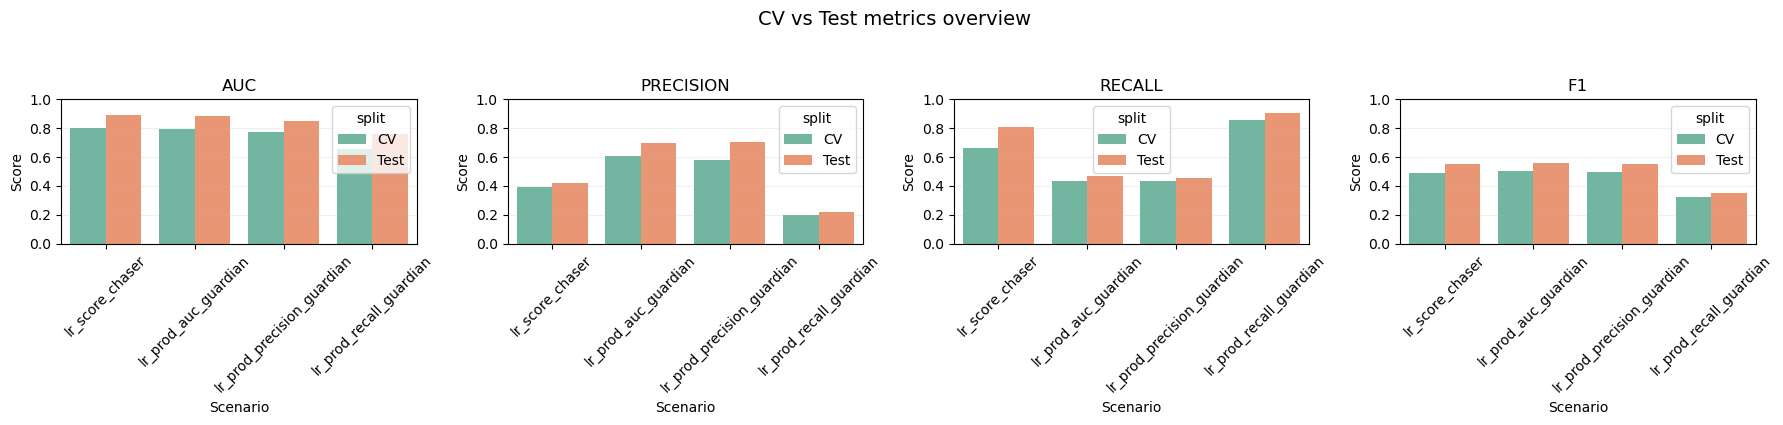

In [11]:

metric_view_cols = [
    "scenario",
    "selection_focus",
    "pipeline",
    "sampler",
    "logistic",
    "threshold",
    "test_auc",
    "test_precision",
    "test_recall",
    "test_f1",
    "cv_auc",
    "cv_precision",
    "cv_recall",
    "cv_f1",
]

comparison_table = summary_df[metric_view_cols].copy()
comparison_table

long_records = []
for _, row in summary_df.iterrows():
    for metric in ["auc", "precision", "recall", "f1"]:
        long_records.append(
            {
                "scenario": row["scenario"],
                "selection_focus": row["selection_focus"],
                "metric": metric.upper(),
                "split": "CV",
                "value": row[f"cv_{metric}"]
                if metric != "auc"
                else row["cv_auc"],
            }
        )
        long_records.append(
            {
                "scenario": row["scenario"],
                "selection_focus": row["selection_focus"],
                "metric": metric.upper(),
                "split": "Test",
                "value": row[f"test_{metric}"]
                if metric != "auc"
                else row["test_auc"],
            }
        )
metric_long_df = pd.DataFrame(long_records)
scenario_order = summary_df["scenario"].tolist()

fig, axes = plt.subplots(1, 4, figsize=(18, 4), sharey=False)
for ax, metric in zip(axes, ["AUC", "PRECISION", "RECALL", "F1"]):
    plot_df = metric_long_df[metric_long_df["metric"] == metric]
    sns.barplot(
        data=plot_df,
        x="scenario",
        y="value",
        hue="split",
        order=scenario_order,
        palette="Set2",
        ax=ax,
    )
    ax.set_title(metric)
    ax.set_xlabel("Scenario")
    ax.set_ylabel("Score")
    ax.set_ylim(0, 1)
    ax.tick_params(axis="x", rotation=45)
    ax.grid(alpha=0.2, axis="y")
fig.suptitle("CV vs Test metrics overview", y=1.05, fontsize=14)
fig.tight_layout()
plt.show()


In [12]:

summary_path = SUMMARY_DIR / "lr_scenario_summary.csv"
summary_df.to_csv(summary_path, index=False)
print(f"Summary saved to {summary_path}")

Summary saved to artifacts\summaries\lr_scenario_summary.csv


In [13]:

for scenario_name, result in scenario_outputs.items():
    artifact_dirs = get_scenario_dirs(scenario_name)
    probs = result["ensemble_probs"]
    threshold = result["threshold"]
    cm = result["confusion_matrix"]

    threshold_metrics_df = result.get("threshold_metrics_df")
    if threshold_metrics_df is None:
        threshold_metrics_df = build_threshold_metrics(y_test_full.values, probs) # type: ignore
    gain_df = result.get("gain_curve_df")
    base_rate = result.get("base_rate")
    if gain_df is None:
        gain_df, base_rate = prepare_cumulative_gain(y_test_full.values, probs) # type: ignore

    fig, axes = plt.subplots(3, 3, figsize=(20, 18))
    plot_roc_curve(axes[0, 0], y_test_full.values, probs, scenario_name) # type: ignore
    plot_pr_curve(axes[0, 1], y_test_full.values, probs, scenario_name) # type: ignore
    plot_confusion(axes[0, 2], cm, labels=["Stay", "Leave"], title="Confusion Matrix") # type: ignore

    plot_cv_distribution(axes[1, 0], result["seeds"], title="CV Fold Distribution")
    plot_calibration(axes[1, 1], y_test_full.values, probs, scenario_name) # type: ignore
    plot_probability_hist(axes[1, 2], y_test_full.values, probs) # type: ignore

    plot_gain_curve(axes[2, 0], gain_df)
    plot_lift_curve(axes[2, 1], gain_df, base_rate if base_rate is not None else float(y_test_full.mean()))
    plot_threshold_sweep(axes[2, 2], threshold_metrics_df)

    fig.suptitle(
        f"{scenario_name}: {result['description']}\n"
        f"Threshold={threshold:.3f}",
        fontsize=16,
        fontweight="bold",
    )
    fig.tight_layout(rect=[0, 0.03, 1, 0.97]) # type: ignore

    dashboard_path = artifact_dirs["figures"] / "dashboard.png"
    fig.savefig(dashboard_path, dpi=150, bbox_inches="tight")
    plt.close(fig)
    print(f"[figure] {dashboard_path}")

[figure] artifacts\lr_score_chaser\figures\dashboard.png
[figure] artifacts\lr_prod_auc_guardian\figures\dashboard.png
[figure] artifacts\lr_prod_precision_guardian\figures\dashboard.png
[figure] artifacts\lr_prod_recall_guardian\figures\dashboard.png


In [14]:

def train_final_bundle(name: str, recipe: Dict[str, Any], threshold: float, artifact_dirs: Dict[str, Path]) -> Dict[str, Any]:
    seeds = recipe.get("seeds", RANDOM_SEEDS)
    bundle = {
        "scenario": name,
        "description": recipe["description"],
        "trained_at": datetime.now().isoformat(),
        "threshold": float(threshold),
        "soft_voting": recipe.get("soft_voting", "mean"),
        "models": [],
        "artifact_dirs": {key: str(val) for key, val in artifact_dirs.items()},
    }

    for seed in seeds:
        pipeline = FeaturePipeline(recipe["feature_pipeline"])
        X_proc, y_proc = pipeline.fit_transform_train(X_train_full, y_train_full.values) # type: ignore

        log_params = dict(recipe["logistic_params"])
        log_params.setdefault("random_state", seed)

        model = LogisticRegression(**log_params)
        model.fit(X_proc, y_proc)

        bundle["models"].append(
            {
                "seed": seed,
                "pipeline": pipeline,
                "model": model,
                "feature_names": pipeline.get_feature_names(),
            }
        )

    path = artifact_dirs["models"] / f"{name}.pkl"
    joblib.dump(bundle, path)
    print(f"[saved] {path}")
    return bundle


def score_bundle(bundle: Dict[str, Any], X: pd.DataFrame, y: np.ndarray) -> Tuple[np.ndarray, Dict[str, float], np.ndarray]:
    prob_stack = []
    for entry in bundle["models"]:
        pipeline = entry["pipeline"]
        model = entry["model"]
        X_proc = pipeline.transform(X)
        prob_stack.append(model.predict_proba(X_proc)[:, 1])
    prob_stack = np.vstack(prob_stack)

    if bundle.get("soft_voting", "mean") == "median":
        probs = np.median(prob_stack, axis=0)
    else:
        probs = np.mean(prob_stack, axis=0)

    metrics = compute_metrics(y, probs, bundle["threshold"])
    preds = (probs >= bundle["threshold"]).astype(int)
    cm = confusion_matrix(y, preds)
    return probs, metrics, cm

In [15]:

model_bundles: Dict[str, Dict[str, Any]] = {}
bundle_rows: List[Dict[str, Any]] = []

for scenario_name, result in scenario_outputs.items():
    artifact_dirs = get_scenario_dirs(scenario_name)
    bundle = train_final_bundle(scenario_name, LR_SCENARIOS[scenario_name], result["threshold"], artifact_dirs)
    model_bundles[scenario_name] = bundle

    probs, metrics, cm = score_bundle(bundle, X_test_full, y_test_full.values) # type: ignore
    preds = (probs >= bundle["threshold"]).astype(int)
    bundle_rows.append(
        {
            "scenario": scenario_name,
            "threshold": round(bundle["threshold"], 4),
            "test_auc": round(metrics["auc"], 4),
            "test_pr_auc": round(metrics["pr_auc"], 4),
            "precision": round(metrics["precision"], 4),
            "recall": round(metrics["recall"], 4),
            "f1": round(metrics["f1"], 4),
            "artifact_base": str(artifact_dirs["base"]),
        }
    )

    coef_records = []
    for entry in bundle["models"]:
        feature_names = entry["feature_names"]
        coefs = entry["model"].coef_.ravel()
        coef_records.extend(
            {"seed": entry["seed"], "feature": feat, "coef": coef_val}
            for feat, coef_val in zip(feature_names, coefs)
        )

    coef_df = pd.DataFrame(coef_records)
    coef_mean = coef_df.groupby("feature")["coef"].mean().sort_values()

    top_neg = coef_mean.head(15)
    top_pos = coef_mean.tail(15)

    fig, ax = plt.subplots(figsize=(10, 8))
    combined = pd.concat([top_neg, top_pos])
    colors = ["#1f77b4" if val < 0 else "#d62728" for val in combined.values]
    combined.plot(kind="barh", ax=ax, color=colors)
    ax.axvline(0, color="black", linewidth=1)
    ax.set_title(f"{scenario_name}: mean coefficients (top +/-)")
    ax.set_xlabel("Coefficient value")
    fig.tight_layout()
    coef_path = artifact_dirs["figures"] / "coefficients.png"
    fig.savefig(coef_path, dpi=150, bbox_inches="tight")
    plt.close(fig)
    print(f"[figure] {coef_path}")

    report_path = artifact_dirs["data"] / "classification_report.json"
    final_report = classification_report(
        y_test_full.values, # type: ignore
        preds,
        zero_division=0,
        output_dict=True,
    )
    with open(report_path, "w", encoding="utf-8") as fp:
        json.dump(final_report, fp, indent=2)
    print(f"[report] {report_path}")

    cm_path = artifact_dirs["data"] / "confusion_matrix.csv"
    cm_df = pd.DataFrame(cm, index=["Actual_Stay", "Actual_Leave"], columns=["Pred_Stay", "Pred_Leave"])
    cm_df.to_csv(cm_path)
    print(f"[matrix] {cm_path}")

    predictions_df = pd.DataFrame(
        {
            "row_index": X_test_full.index,
            "predicted_probability": probs,
            "prediction": preds,
            "actual": y_test_full.values,
        }
    )
    pred_path = artifact_dirs["data"] / "test_predictions.csv"
    predictions_df.to_csv(pred_path, index=False)
    print(f"[data] {pred_path}")

    cv_rows = []
    for seed_info in result["seeds"]:
        for fold_idx, score in enumerate(seed_info["cv_scores"]):
            cv_rows.append({"seed": seed_info["seed"], "fold": fold_idx, "auc": score})
    cv_df = pd.DataFrame(cv_rows)
    cv_path = artifact_dirs["data"] / "cv_fold_scores.csv"
    cv_df.to_csv(cv_path, index=False)
    print(f"[data] {cv_path}")

    threshold_metrics_df = build_threshold_metrics(y_test_full.values, probs) # type: ignore
    threshold_path = artifact_dirs["data"] / "threshold_sweep.csv"
    threshold_metrics_df.to_csv(threshold_path, index=False)
    print(f"[data] {threshold_path}")

    gain_df, base_rate = prepare_cumulative_gain(y_test_full.values, probs) # type: ignore
    gain_path = artifact_dirs["data"] / "cumulative_gain.csv"
    gain_df.to_csv(gain_path, index=False)
    print(f"[data] {gain_path}")

    scenario_outputs[scenario_name]["test_predictions"] = predictions_df
    scenario_outputs[scenario_name]["threshold_metrics_df"] = threshold_metrics_df
    scenario_outputs[scenario_name]["gain_curve_df"] = gain_df
    scenario_outputs[scenario_name]["base_rate"] = base_rate
    scenario_outputs[scenario_name]["cv_folds_df"] = cv_df

bundle_summary_df = pd.DataFrame(bundle_rows).sort_values("test_auc", ascending=False)
bundle_summary_path = SUMMARY_DIR / "lr_bundle_summary.csv"
bundle_summary_df.to_csv(bundle_summary_path, index=False)
print(f"Bundle summary written to {bundle_summary_path}")
bundle_summary_df

[saved] artifacts\lr_score_chaser\models\lr_score_chaser.pkl
[figure] artifacts\lr_score_chaser\figures\coefficients.png
[report] artifacts\lr_score_chaser\data\classification_report.json
[matrix] artifacts\lr_score_chaser\data\confusion_matrix.csv
[data] artifacts\lr_score_chaser\data\test_predictions.csv
[data] artifacts\lr_score_chaser\data\cv_fold_scores.csv
[data] artifacts\lr_score_chaser\data\threshold_sweep.csv
[data] artifacts\lr_score_chaser\data\cumulative_gain.csv
[saved] artifacts\lr_prod_auc_guardian\models\lr_prod_auc_guardian.pkl
[figure] artifacts\lr_prod_auc_guardian\figures\coefficients.png
[report] artifacts\lr_prod_auc_guardian\data\classification_report.json
[matrix] artifacts\lr_prod_auc_guardian\data\confusion_matrix.csv
[data] artifacts\lr_prod_auc_guardian\data\test_predictions.csv
[data] artifacts\lr_prod_auc_guardian\data\cv_fold_scores.csv
[data] artifacts\lr_prod_auc_guardian\data\threshold_sweep.csv
[data] artifacts\lr_prod_auc_guardian\data\cumulative_ga

,scenario,threshold,test_auc,test_pr_auc,precision,recall,f1,artifact_base
0,lr_score_chaser,0.500,0.8853,0.6838,0.4019,0.8113,0.5375,artifacts\lr_score_chaser
1,lr_prod_auc_guardian,0.815,0.8789,0.6355,0.6222,0.5283,0.5714,artifacts\lr_prod_auc_guardian
2,lr_prod_precision_guardian,0.735,0.8459,0.6203,0.5472,0.5472,0.5472,artifacts\lr_prod_precision_guardian
3,lr_prod_recall_guardian,0.500,0.7246,0.3251,0.1974,0.8491,0.3203,artifacts\lr_prod_recall_guardian


In [ ]:

summary_df = summary_df.merge(bundle_summary_df[["scenario", "artifact_base"]], on="scenario", how="left")
scenario_focus = {
    "lr_score_chaser": "Test AUC benchmark",
    "lr_prod_auc_guardian": "Production CV AUC",
    "lr_prod_precision_guardian": "Production CV precision",
    "lr_prod_recall_guardian": "Production CV recall",
}
summary_df["recommended_for"] = summary_df["scenario"].map(scenario_focus).fillna("Review")

recommendations = (
    summary_df.sort_values(["priority", "leaderboard_score"], ascending=False)
    [
        "recommended_for",
        "scenario",
        "selection_focus",
        "test_auc",
        "test_precision",
        "test_recall",
        "test_f1",
        "cv_auc",
        "cv_precision",
        "cv_recall",
        "cv_f1",
        "cv_mean",
        "cv_std",
        "cv_mean_minus_std",
        "leaderboard_score",
        "production_score",
        "artifact_base",
    ]
)
recommendations

summary_df.to_csv(summary_path, index=False)
print(f"Enriched summary written to {summary_path}")


,scenario,description,selection_focus,priority,pipeline,sampler,logistic,threshold_key,cv_signature,soft_voting,...,cv_f1,cv_mean,cv_std,cv_mean_minus_std,auc_delta,leaderboard_score,production_score,artifact_base_x,recommended_for,artifact_base_y
0,lr_score_chaser,Legacy advanced stack tuned purely for leaderb...,test_auc_leaderboard,10.0,classic_advanced,smote_only,very_high_l2,default,kfold_5,mean,...,0.4917,0.7956,0.0390,0.7565,0.0116,0.78930,0.51978,artifacts\lr_score_chaser,Test AUC benchmark,artifacts\lr_score_chaser
1,lr_prod_auc_guardian,Quantile/bin stack + ADASYN→Borderline sparse ...,cv_auc,9.0,quantile_bins,adasyn_border,saga_l1,max_f1,kfold_5,median,...,0.5049,0.7841,0.0378,0.7463,0.0019,0.78566,0.51654,artifacts\lr_prod_auc_guardian,Production CV AUC,artifacts\lr_prod_auc_guardian
2,lr_prod_precision_guardian,Full-stack + SMOTETomek with balanced L2 tuned...,cv_precision,8.5,full_stack,smote_tomek,balanced_l2,max_f1,kfold_5,median,...,0.4952,0.7539,0.0484,0.7054,-0.0273,0.76219,0.50364,artifacts\lr_prod_precision_guardian,Production CV precision,artifacts\lr_prod_precision_guardian
3,lr_prod_recall_guardian,Advanced poly stack + SMOTETomek + sparse LR t...,cv_recall,8.0,advanced_poly,smote_tomek,saga_l1,recall_guard,kfold_5,median,...,0.3208,0.6178,0.0932,0.5246,-0.1208,0.63710,0.48688,artifacts\lr_prod_recall_guardian,Production CV recall,artifacts\lr_prod_recall_guardian
